# Style Transfer

Style Transfer is modifying the style of an image while still preserving its context.

In this tutorial, we will learn how to use deep learning to compose images in the style of another image.


Through-out this tutorial we will be using the following librarys:

- NumPy - Linear Algebra Library that most other libaries reply in as one of their building blocks
- PIL - Python Imaging Library. Provides a number of factory functions, including functions to load images from files, and to create new images.
- io - Python’s main facilities for dealing with various types of I/O.
- keras -  High-level neural networks API
- scipy - Python-based ecosystem of open-source software for mathematics, science, and engineering. 



In [0]:
# Imports
from __future__ import print_function
import numpy as np
from PIL import Image
import requests
from io import BytesIO

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b

## Load Data

Below the links to both the content image and style image has been provided

In [0]:
#Lets start by defining the input image 
# San Francisco
san_francisco_image_path = "https://ai-camp-content.s3.amazonaws.com/inputImage.jpg"

#Define the style image
# Warsaw by Tytus Brzozowski, http://t-b.pl
tytus_image_path = "https://ai-camp-content.s3.amazonaws.com/styleImage.jpg"


## Clean Data

ToDo:
- Open the images from the URL's provided
- Resize the images 
- Save the newly resized images




In [15]:
#Open and identify the content image from its URL.
input_image = Image.open(BytesIO(requests.get(san_francisco_image_path).content))
input_image

Output hidden; open in https://colab.research.google.com to view.

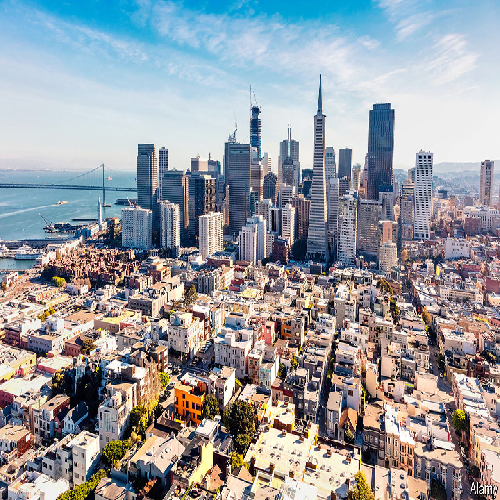

In [16]:
#Set the height and width for the images
IMAGE_HEIGHT = 500
IMAGE_WIDTH = 500

#Resize the content image passing in the width and height into the .resize() function
input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))

#Save the newly sized image
input_image.save('input_image.png')

#Display the image
input_image

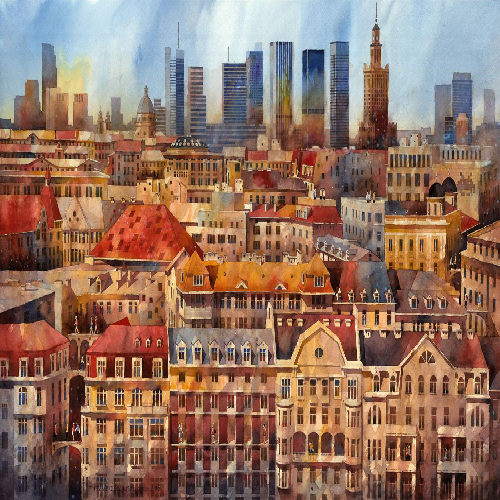

In [17]:
#Open and identify the style image from its URL.
style_image = Image.open(BytesIO(requests.get(tytus_image_path).content))

#Resize the input image passing in the width and height into the .resize() function
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))

#Save the newly sized image
style_image.save('style_image.png')

#Display the image
style_image

In [0]:
#Data normalization and reshaping from RGB to BGR to convert images into a 
#suitable form for processing

#Convert the content image to an array using NumPys asarray() function
input_image_array = np.asarray(input_image, dtype = 'float32')

#Expand the shape of the array using NumPy's expand_dims(), so that we can 
#later concatenate the representations of these two images into a common data structure.
input_image_array = np.expand_dims(input_image_array, axis = 0)

#Now we need to compress the input data by performaing two transformations
#1. Subtracting the RGB mean value from each pixel
#2. Changeing the ordering of array from RGB to BGR 
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]

input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
input_image_array = input_image_array[:, :, :, ::-1]

style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array = style_image_array[:, :, :, ::-1]



## Model

In this tutorial we will load our tensors into the pre-trained VGG16 model. This will allow us to extract the feature maps and subsequently the content and style representations of the content, style and generated images.


ToDo:
- Set up backend variables (https://www.tensorflow.org/api_docs/python/tf/keras/backend/variable)
- Concatenate the images 


In [0]:
#Add the content image as a keras backend variable
input_image = backend.variable(input_image_array)

#Add the style image as a keras backend variable
style_image = backend.variable(style_image_array)


#Instantiate a placeholder tensor to store the combination image that retains 
#the content of the content image while incorporating the style of the style image.
combination_image = backend.placeholder(shape=(1, IMAGE_HEIGHT, IMAGE_WIDTH, 3))

#Concatenate the context, style and combination image alongside the specified 
#axis 0 using keras backend.concatenate()
to_concatenate = [input_image, style_image, combination_image]

concatenate = backend.concatenate(to_concatenate, axis = 0)

#Using the pre-trained VGG16 model(16 layer model)- one of Keras applications. 
#It is a convolutional neural network tained on ImageNet include top is whether 
#to include the 3 fully-connected layers at the top of the network
#since we are not interested in image classification we set this value to false
model = VGG16(input_tensor=concatenate, include_top=False)

In [0]:
#Construct a dictionary to easily look up layers by their names
layers = dict([(layer.name, layer.output) for layer in model.layers])

In [21]:
input_image.shape
style_image.shape
combination_image.shape

TensorShape([Dimension(1), Dimension(500), Dimension(500), Dimension(3)])

##Content Loss

In order to preserve original content, we are going to minimize the distance between an input image and an output image.

ToDo:
- Work out the content loss

In [22]:
CONTENT_WEIGHT = 0.02

#For the content loss, we draw the content feature from the block2_conv2 layer.
content_layer = "block2_conv2"
layer_features = layers[content_layer]

content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

#The content loss is the squared Euclidean distance between content and combination images.
#Use backend sum() and square() functions
CONTENT_LOSS = backend.sum(backend.square(combination_features - content_image_features
                                         ))

loss = backend.variable(0.)
loss += CONTENT_WEIGHT * CONTENT_LOSS

W0823 11:05:04.837122 139649995810688 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


## Gram Matrix

Represents the similarity or difference between two images

To do this we similarly convert all images to vector form and form a matrix

In [0]:
def gram_matrix(x):
    #Turn a nD tensor into a 2D tensor with same 0th dimension. In other words, 
    #it flattens each data samples of a batch.
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    
    # .dot Multiplies 2 tensors (and/or variables) and returns a tensor.
    gram = backend.dot(features, backend.transpose(features))
    return gram

## Style Loss

We obtain the style loss by calculating Frobenius norm (the matrix norm of a matrix defined as the square root of the sum of the absolute squares of its elements) of the difference between the Gram matrices of the style and combination images.

###TODO:
  - Complete the compute_style_loss function
  - Convert the style and combination images into gram matrix using the function above
  - Define the image size using variables declared at the beginning of the notebook
  - Calculate the style loss in the same way done above (Hint: squared Euclidean distance between ***style*** and combination images)


In [0]:
CHANNELS = 3
STYLE_WEIGHT = 4.5

def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT*IMAGE_WIDTH
    style_loss = backend.sum(backend.square(style - combination))
    return style_loss / (4. * (CHANNELS ** 2) * (size ** 2))
  
#The style layers that we are interested in
style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]

for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (STYLE_WEIGHT / len(style_layers)) * style_loss

## Total Variation Loss 

Helps reduce the noise in the composite image. 

It encourages spatial smoothness in the generated image.

In [0]:
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)

## Loss and Gradients
Now we have our content loss, style loss, and total variation loss set, we want to define our style transfer process as an optimization problem where we are going to minimize our global loss - which is a combination of content, style and total variation losses

In [29]:
outputs = [loss]

# Now we have our total loss , its time to optimize the resultant image.We start by defining gradients
outputs += backend.gradients(loss, combination_image)

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

W0823 11:08:42.380101 139649995810688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Iteration 0 completed with loss 99425804288
Iteration 1 completed with loss 40375820288
Iteration 2 completed with loss 28595511296
Iteration 3 completed with loss 24663404544
Iteration 4 completed with loss 23132725248


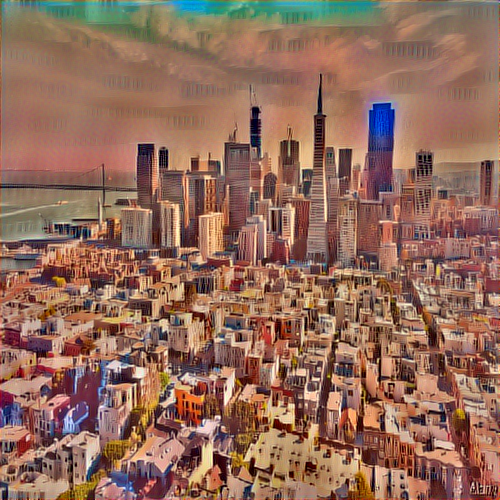

In [30]:
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

ITERATIONS = 5

#This resultant image is initially a random collection of pixels, so we use 
#(fmin_l_bfgs_b - Limited-memory BFGS) which is an optimization algorithm
for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, 
                                  x.flatten(), 
                                  fprime=evaluator.gradients, 
                                  maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    
#To get back output image do the following
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1]
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save("output.png")
output_image

## Visualizing Combined Results

In [0]:
#Save a combined image to file
combined = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, ['input_image.png', 'style_image.png', 'output.png']):
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save('combinedImage.png')

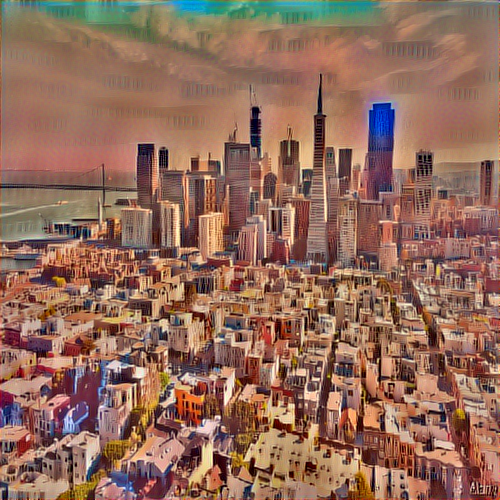

In [35]:
#Display the content, style, and output images
input_image
style_image
output_image

## Exercise 1

Upload your own images and try this task again

## Exercise 2

I'm sure alot of you have seen or heard of the the [FaceApp challenge recently.](https://inews.co.uk/news/technology/faceapp-challenge-old-age-filter-app-pictures/) For this exercise play around with what you have learnt today to try and make someone look younger or older by using style transfer!

<br>
<table style="width:100%">
  <tr>
    <td>
       <img src="https://scontent-lhr3-1.xx.fbcdn.net/v/t1.15752-9/67961780_369776100354470_6825263118554234880_n.jpg?_nc_cat=110&_nc_oc=AQnXKTaauNI2feFPc8qDEu-oCKpOqbzLrcijvzSi4lc4doNfUnB1x_0Q4Qiu_yyxXLg&_nc_ht=scontent-lhr3-1.xx&oh=e1bd52874e658fdae81004015e9b4291&oe=5DCDC963" height="600">
    </td>
    <td>
      <img src="https://scontent-lhr3-1.xx.fbcdn.net/v/t1.15752-9/67793675_512368569590133_2198251166461067264_n.jpg?_nc_cat=108&_nc_oc=AQnF14gcCHySCSdxvs82iMfrFwoq73t8Ch3kBFHKcccouMJOrvnldFVZtc0JbuFNI5o&_nc_ht=scontent-lhr3-1.xx&oh=b84000bdfbc198612e0a09b1a692ddf0&oe=5DD11FB3" height="600">
   </td> 
  </tr>
</table>